# Proyek Klasifikasi Gambar Assignment 4

Nama : Nisrina Fatimah Parisya

ID Cohort : MC006D5X1393


**Import Library**

In [4]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


**Load Dataset**

In [5]:
!pip install -q kaggle

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nisrinafatimah","key":"436a6c6f10dd03776b0e707878b9194a"}'}

In [7]:
!chmod 600 /content/kaggle.json

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [9]:
# Download dataset
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

# Unzip hasil download
!unzip eye-diseases-classification.zip -d eye_disease_data

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
Archive:  eye-diseases-classification.zip
  inflating: eye_disease_data/dataset/cataract/0_left.jpg  
  inflating: eye_disease_data/dataset/cataract/103_left.jpg  
  inflating: eye_disease_data/dataset/cataract/1062_right.jpg  
  inflating: eye_disease_data/dataset/cataract/1083_left.jpg  
  inflating: eye_disease_data/dataset/cataract/1084_right.jpg  
  inflating: eye_disease_data/dataset/cataract/1102_left.jpg  
  inflating: eye_disease_data/dataset/cataract/1102_right.jpg  
  inflating: eye_disease_data/dataset/cataract/1115_left.jpg  
  inflating: eye_disease_data/dataset/cataract/1126_right.jpg  
  inflating: eye_disease_data/dataset/cataract/112_right.jpg  
  inflating: eye_disease_data/dataset/cataract/1144_left.jpg  
  inflating: eye_disease_data/dataset/cataract/1144_right.jpg  
  inflating: eye_disease_data/dataset/cataract/1164_left.jpg  
  inflating: eye_disease_dat

## Gabungan Data

In [10]:
cataract_dir = '/content/eye_disease_data/dataset/cataract'
diabetic_dir = '/content/eye_disease_data/dataset/diabetic_retinopathy'
glaucoma_dir = '/content/eye_disease_data/dataset/glaucoma'
normal_dir = '/content/eye_disease_data/dataset/normal'

# Direktori baru untuk dataset gabungan
combined_dir = "/content/eye_disease_data/dataset/gabunganData"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

def salin_semua_gambar(folder_asal, label):
    path_label = os.path.join(combined_dir, label)
    os.makedirs(path_label, exist_ok=True)

    for nama_file in os.listdir(folder_asal):
        path_file = os.path.join(folder_asal, nama_file)
        if os.path.isfile(path_file):
            shutil.copy2(path_file, os.path.join(path_label, nama_file))

# Jalankan untuk setiap kelas
salin_semua_gambar(cataract_dir, 'cataract')
salin_semua_gambar(diabetic_dir, 'diabetic_retinopathy')
salin_semua_gambar(glaucoma_dir, 'glaucoma')
salin_semua_gambar(normal_dir, 'normal')

print("Semua gambar berhasil disalin ke folder gabungan.")

Semua gambar berhasil disalin ke folder gabungan.


## Dataset Checking

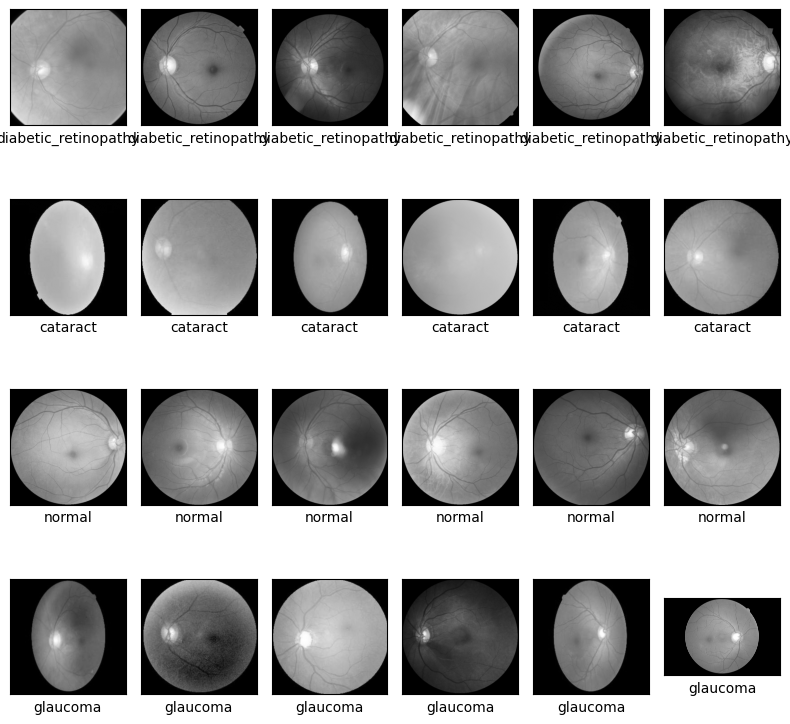

In [11]:
#Untuk menyimpan gambar
eyedisease_pict = {}

path = "/content/eye_disease_data/dataset/gabunganData"
for disease_type in os.listdir(path):
    disease_folder = os.path.join(path, disease_type)
    if os.path.isdir(disease_folder):
        eyedisease_pict[disease_type] = os.listdir(disease_folder)


fig, axs = plt.subplots(len(eyedisease_pict), 6, figsize=(8, 8))
for row_index, (disease_type, image_list) in enumerate(eyedisease_pict.items()):
    selected_images = np.random.choice(image_list, 6, replace=False)

    for col_index, image_name in enumerate(selected_images):
        image_path = os.path.join(path, disease_type, image_name)
        img = Image.open(image_path).convert("L")  # Ubah ke grayscale
        axs[row_index, col_index].imshow(img, cmap='gray')
        axs[row_index, col_index].set(xlabel=disease_type, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

## Plot Distribusi

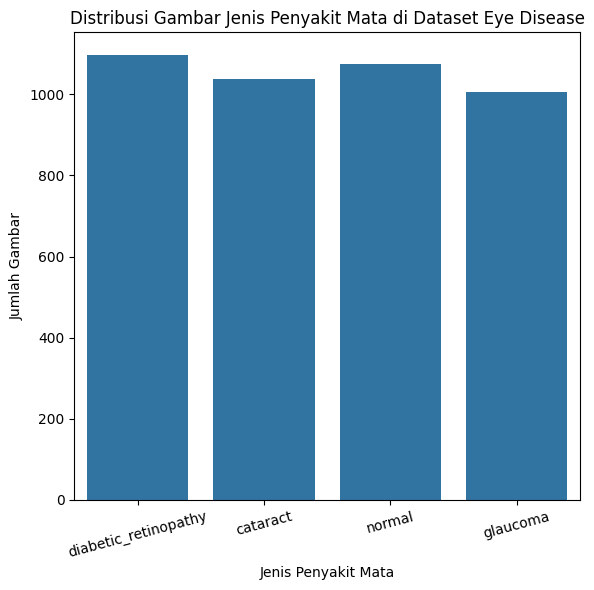

In [12]:
eyedisease_pict = '/content/eye_disease_data/dataset/gabunganData'

distribusi_disease =[]
label = []
full_path = []

for path, _, files in os.walk(eyedisease_pict):
    for name in files:
        full_path.append(os.path.join(path, name))
        label.append(os.path.basename(path))
        distribusi_disease.append(name)
eye_df = pd.DataFrame({
    "file_path": full_path,
    "file_name": distribusi_disease,
    "label": label
})

# Visualisasi distribusi label
plt.figure(figsize=(6, 6))
sns.countplot(x="label", data=eye_df)
plt.title("Distribusi Gambar Jenis Penyakit Mata di Dataset Eye Disease")
plt.xlabel("Jenis Penyakit Mata")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## Data Splitting

In [13]:
usePath ='/content/eye_disease_data/dataset/gabunganData'

namafile = []
jenisPenyakit = []
paths = []

for root, subdirs, files in os.walk(usePath):
    for file in files:
        paths.append(os.path.join(root, file))
        jenisPenyakit.append(root.split('/')[-1])
        namafile.append(file)

# Membuat DataFrame dengan informasi file gambar
eye_disease_df = pd.DataFrame({
    "path": paths,
    "file_name": namafile,
    "Jenis Penyakit": jenisPenyakit
})

# Melihat jumlah gambar
eye_disease_df.groupby('Jenis Penyakit').size()

,0
Jenis Penyakit,
cataract,1038
diabetic_retinopathy,1098
glaucoma,1007
normal,1074


In [15]:
x = eye_disease_df['path']
y = eye_disease_df['Jenis Penyakit']

# Split 80% untuk train+val dan 20% untuk test
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=300)

# Dari 80% tadi, split lagi menjadi 75% train dan 25% val
# (0.25 * 0.8 = 0.2 jadi val 20% dari total data)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state=300)

print(f"Train: {len(x_train)}")
print(f"Validation: {len(x_val)}")
print(f"Test: {len(x_test)}")


Train: 2529
Validation: 844
Test: 844


In [16]:
train_df = pd.DataFrame({'path':x_train,'labels':y_train,'set':'train'})
test_df = pd.DataFrame({'path':x_test,'labels':y_test,'set':'test'})
val_df = pd.DataFrame({'path':x_val,'labels':y_val,'set':'val'})

df_allData = pd.concat([train_df,test_df,val_df],ignore_index=True)
print(df_allData.groupby(['set', 'labels']).size(), '\n')

set    labels              
test   cataract                223
       diabetic_retinopathy    229
       glaucoma                196
       normal                  196
train  cataract                634
       diabetic_retinopathy    638
       glaucoma                598
       normal                  659
val    cataract                181
       diabetic_retinopathy    231
       glaucoma                213
       normal                  219
dtype: int64 



In [17]:
print(df_allData.sample(5))

                                                   path                labels  \
559   /content/eye_disease_data/dataset/gabunganData...  diabetic_retinopathy   
4073  /content/eye_disease_data/dataset/gabunganData...              glaucoma   
651   /content/eye_disease_data/dataset/gabunganData...              cataract   
271   /content/eye_disease_data/dataset/gabunganData...  diabetic_retinopathy   
421   /content/eye_disease_data/dataset/gabunganData...              cataract   

        set  
559   train  
4073    val  
651   train  
271   train  
421   train  


In [19]:
dataSource_path = '/content/eye_disease_data/dataset/gabunganData'
dataset_path = 'FIX_FINAL_DATASET'

In [20]:
#cek directory
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

for index, row in df_allData.iterrows():
    source_path = row['path']
    destination_dir = os.path.join(dataset_path, row['set'], row['labels'])

    os.makedirs(destination_dir, exist_ok=True)

    # tentuin path yg dituju
    destination_path = os.path.join(destination_dir, os.path.basename(source_path))

    # cek source file
    if os.path.exists(source_path):
        shutil.copy2(source_path, destination_path)
    else:
        print(f"File not found: {source_path}")


In [21]:
TRAIN_DIR = "FIX_FINAL_DATASET/train/"
TEST_DIR = "FIX_FINAL_DATASET/test/"

# training set
train_cataract = os.path.join(TRAIN_DIR, 'cataract')
train_retinopathy = os.path.join(TRAIN_DIR, 'diabetic_retinopathy')
train_glaucoma = os.path.join(TRAIN_DIR, 'glaucoma')
train_normal = os.path.join(TRAIN_DIR, 'normal')

# test set
test_cataract = os.path.join(TEST_DIR, 'cataract')
test_retinopathy = os.path.join(TEST_DIR, 'diabetic_retinopathy')
test_glaucoma = os.path.join(TEST_DIR, 'glaucoma')
test_normal = os.path.join(TEST_DIR, 'normal')


# output
print("Training set:")
print(" - Cataract: ", len(os.listdir(train_cataract)))
print(" - Diabetic Retinopathy: ", len(os.listdir(train_retinopathy)))
print(" - Glaucoma: ", len(os.listdir(train_glaucoma)))
print(" - Normal: ", len(os.listdir(train_normal)))

print("\nTest set:")
print(" - Cataract: ", len(os.listdir(test_cataract)))
print(" - Diabetic Retinopathy: ", len(os.listdir(test_retinopathy)))
print(" - Glaucoma: ", len(os.listdir(test_glaucoma)))
print(" - Normal: ", len(os.listdir(test_normal)))

Training set:
 - Cataract:  634
 - Diabetic Retinopathy:  638
 - Glaucoma:  598
 - Normal:  659

Test set:
 - Cataract:  223
 - Diabetic Retinopathy:  229
 - Glaucoma:  196
 - Normal:  196


In [22]:
TRAIN_DIR = "FIX_FINAL_DATASET/train/"
VAL_DIR = "FIX_FINAL_DATASET/val/"
TEST_DIR = "FIX_FINAL_DATASET/test/"

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk training
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=32,
    class_mode='categorical',  # multiclass classification
    shuffle=True
)

# Generator untuk validation
validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generator untuk testing
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 2529 images belonging to 4 classes.
Found 844 images belonging to 4 classes.
Found 844 images belonging to 4 classes.


## Modeling

In [23]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # prevent overfitting
    Dense(4, activation='softmax')  # multiclass (4 kelas)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='categorical_crossentropy',  # multiclass
              metrics=['accuracy'])

# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = train_generator.classes
class_names = list(train_generator.class_indices.keys())

# Hitung bobot
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = {i: w for i, w in enumerate(class_weights_array)}

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 293ms/step - accuracy: 0.3783 - loss: 1.5163 - val_accuracy: 0.5320 - val_loss: 0.9525
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 33s 242ms/step - accuracy: 0.5602 - loss: 0.9242 - val_accuracy: 0.7145 - val_loss: 0.7366
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 262ms/step - accuracy: 0.5979 - loss: 0.8418 - val_accuracy: 0.6576 - val_loss: 0.7170
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - accuracy: 0.7021 - loss: 0.6757 - val_accuracy: 0.7796 - val_loss: 0.5712
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - accuracy: 0.7403 - loss: 0.5947 - val_accuracy: 0.7891 - val_loss: 0.5132
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step - accuracy: 0.7634 - loss: 0.5697 - val_accuracy: 0.7891 - val_loss: 0.5899
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - accuracy: 0.8027 - loss: 0.5290 - val_accuracy: 0.7903 - val_loss: 0.5196
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 243ms/step - accuracy: 0.8024 - loss: 0.5036 - val_accu

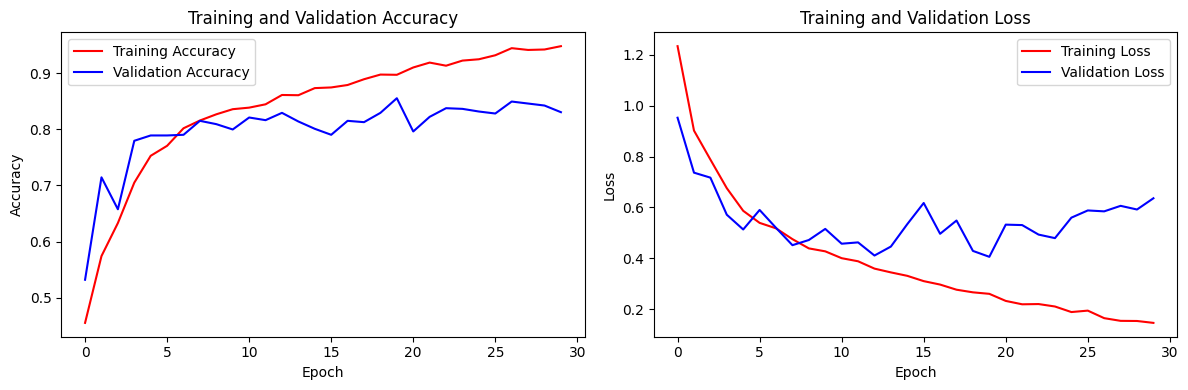

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



Classification Report:
                      precision    recall  f1-score   support

            Cataract     0.8257    0.8924    0.8578       223
Diabetic Retinopathy     1.0000    1.0000    1.0000       229
            Glaucoma     0.8506    0.6684    0.7486       196
              Normal     0.7727    0.8673    0.8173       196

            accuracy                         0.8637       844
           macro avg     0.8623    0.8570    0.8559       844
        weighted avg     0.8665    0.8637    0.8616       844



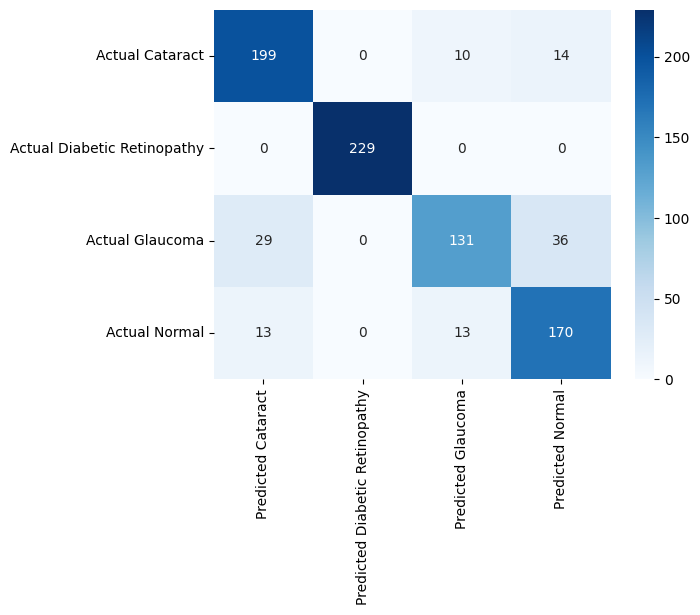

In [28]:
# Prediksi pada test set
test_generator.reset()  # Reset test generator untuk memastikan dimulai dari awal

# Prediksi kelas
preds = model.predict(test_generator, verbose=0)
preds = preds.copy()
preds = preds.argmax(axis=1)

# Confusion Matrix
cm = pd.DataFrame(
    data=confusion_matrix(test_generator.classes, preds, labels=[0, 1, 2, 3]),
    index=["Actual Cataract", "Actual Diabetic Retinopathy", "Actual Glaucoma", "Actual Normal"],
    columns=["Predicted Cataract", "Predicted Diabetic Retinopathy", "Predicted Glaucoma", "Predicted Normal"]
)

# Visualisasi Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

#  Classification Report
print("\nClassification Report:")
print(classification_report(
    y_true=test_generator.classes,
    y_pred=preds,
    target_names=['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal'],
    digits=4
))


In [29]:
# SAVEDMODEL
saved_model_dir = 'saved_model_eye/'
model.export(saved_model_dir)
print(f"> SavedModel tersimpan di: {saved_model_dir}/")

Saved artifact at 'saved_model_eye/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136163812938512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136163812939280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136163812942160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136163812941008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136163812941584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136163812942928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136163812938704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136163812943312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136163812943696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136163812945232: TensorSpec(shape=(), dtype=tf.resource, name=None)
> SavedModel ter

In [38]:
# TF-LITE
# converter dari SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

tflite_path = 'tflite/eye_model.tflite'
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

# Simpan label.txt
labels = ['cataract', 'diabetic retinopathy', 'glaucoma', 'normal']
label_path = 'tflite/label.txt'
with open(label_path, 'w') as f:
    for label in labels:
        f.write(label + '\n')

In [32]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [33]:
import tensorflowjs as tfjs
#TFJS
tfjs_target_dir = 'tfjs_model/'
tfjs.converters.save_keras_model(model, tfjs_target_dir)
print(f"> TFJS model tersimpan di folder: {tfjs_target_dir}/")

failed to lookup keras version from the file,
    this is likely a weight only file
> TFJS model tersimpan di folder: tfjs_model//


In [34]:
import shutil
shutil.make_archive('saved_model_eye', 'zip', 'saved_model_eye')

'/content/saved_model_eye.zip'

In [35]:
import shutil
shutil.make_archive('tfjs_model', 'zip', 'tfjs_model')

'/content/tfjs_model.zip'

In [39]:
import shutil
shutil.make_archive('tflite', 'zip', 'tflite')

'/content/tflite.zip'

In [42]:
!pip freeze | grep 'numpy\|pandas\|matplotlib\|seaborn\|tqdm\|opencv\|Pillow\|scikit-image\|scikit-learn\|tensorflow' > requirements.txt
!cat requirements.txt

geopandas==1.0.1
matplotlib==3.10.0
matplotlib-inline==0.1.7
matplotlib-venn==1.1.2
numpy==2.0.2
opencv-contrib-python==4.11.0.86
opencv-python==4.11.0.86
opencv-python-headless==4.11.0.86
pandas==2.2.2
pandas-datareader==0.10.0
pandas-gbq==0.28.0
pandas-stubs==2.2.2.240909
scikit-image==0.25.2
scikit-learn==1.6.1
seaborn==0.13.2
sklearn-pandas==2.2.0
tensorflow==2.18.0
tensorflow-datasets==4.9.8
tensorflow-hub==0.16.1
tensorflow-io-gcs-filesystem==0.37.1
tensorflow-metadata==1.17.1
tensorflow-probability==0.25.0
tensorflow-text==2.18.1
tensorflow_decision_forests==1.11.0
tensorflowjs==4.22.0
tqdm==4.67.1


In [44]:
%%writefile README.md

# 🧠 Proyek Klasifikasi Penyakit Mata Berdasarkan Gambar Retina
Proyek ini merupakan bagian dari pemenuhan tugas modul Pengembangan Machine Learning, Saya mengambil contoh studi kasus dimana modeling ini nantinya digunakan untuk
mengklasifikasikan penyakit mata yang diambil dari dataset kaggle 'https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification'.

## 🩺 Deskripsi Dataset

Dataset ini terdiri dari gambar retina manusia yang diklasifikasikan ke dalam empat kategori:
- **Katarak**
- **Glaukoma**
- **Retinopati**
- **Normal**

Tujuan dari proyek ini adalah membangun model klasifikasi berbasis CNN (Convolutional Neural Network) untuk mengidentifikasi jenis penyakit berdasarkan citra retina.

---

## 📁 Isi Notebook

a. **Import Library**
   - Inisiasi seluruh dependensi dan library yang digunakan, seperti TensorFlow, NumPy, Matplotlib, dll.

b. **Eksplorasi Dataset**
   - Pemeriksaan struktur dataset.
   - Visualisasi distribusi jumlah gambar untuk setiap label/kategori.

c. **Preprocessing**
   - Resize gambar ke dimensi tertentu.

   - Pembagian dataset menjadi tiga bagian: **train**, **validation**, dan **test**.

d. **Pembuatan dan Pelatihan Model**
   - Membangun model CNN sederhana dengan 32 neuron pada layer awal.
   - Pelatihan model menggunakan data latih dan validasi.

e. **Evaluasi Model**
   - Evaluasi performa model menggunakan data uji.
   - Menampilkan akurasi dan loss, serta metrik tambahan jika diperlukan.

---

## ▶️ Cara Menjalankan Notebook
- Pastikan semua library dan dependensi yang akan digunakan sudah terpasang
- Jalankan kode di dalam sel notebook proyek ini
- Selalu cek kembali apakah path yang telah dibuat tersinkronasi dengan dataset dan folder yang tersedia

Writing README.md
